In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import random

# PROJECT_DIR = "/home/michal/Github/SRF_Linda_RNA"
PROJECT_DIR = "D:/Github/SRF_Linda_RNA"
WORKING_DIR = f"{PROJECT_DIR}/combine_data"
os.chdir(WORKING_DIR)
sys.path.insert(0, WORKING_DIR)
def df_to_markdown(df, floatfmt=".4f"):
    """
    Converts a pandas DataFrame to a Markdown table string.
    Handles float formatting.
    """
    # Get column headers
    headers = [str(col) for col in df.columns]
    
    # Add index name if DataFrame has an index name
    if df.index.name:
        headers.insert(0, str(df.index.name))
    else:
        headers.insert(0, "") # Empty string for unnamed index column

    # Create header row and separator
    header_row = "| " + " | ".join(headers) + " |"
    separator_row = "|-" + "-|-".join(["-" * len(h) for h in headers]) + "-|"

    # Format data rows
    data_rows = []
    for index, row in df.iterrows():
        # Convert index to string for the first column
        row_data = [str(index)] + [
            f"{val:{floatfmt}}" if isinstance(val, (float, np.floating)) else str(val)
            for val in row.values
        ]
        data_rows.append("| " + " | ".join(row_data) + " |")

    return "\n".join([header_row, separator_row] + data_rows)

# Import the new DGE analysis module
from functions import *

# Set seeds for all random number generators
random_seed = 0
np.random.seed(random_seed)
random.seed(random_seed)

In [2]:
def calculate_and_plot_proportions(adata, annotation_key, group_key, output_dir, plot_output_dir):
    """
    Calculates and plots cell type proportions for a given annotation key.

    Args:
        adata (ad.AnnData): Annotated data object.
        annotation_key (str): The key in adata.obs to calculate proportions for (e.g., 'cell_type').
        group_key (str): The key in adata.obs to group samples by (e.g., 'group').
        output_dir (str): Directory to save the proportions table.
        plot_output_dir (str): Directory to save the plot.
    """
    print(f"\nCalculating proportions for: {annotation_key}...")
    if annotation_key not in adata.obs.columns:
        print(f"Warning: Annotation key '{annotation_key}' not found in adata.obs. Skipping.")
        return

    # Ensure the annotation key is categorical for proper plotting/legend handling
    if not pd.api.types.is_categorical_dtype(adata.obs[annotation_key]): # type: ignore
         print(f"Converting '{annotation_key}' to categorical.")
         adata.obs[annotation_key] = adata.obs[annotation_key].astype('category')

    # Calculate counts for each category within each group
    counts_df = adata.obs.groupby([group_key, annotation_key]).size().unstack(fill_value=0)

    # Calculate proportions
    proportions_df = counts_df.apply(lambda x: x / x.sum() if x.sum() > 0 else x, axis=1) # Avoid division by zero
    print(f"Proportions calculated for {annotation_key}.")

    # Save proportions table
    proportions_filename = f'{annotation_key}_proportions_by_{group_key}.csv'
    proportions_output_path = os.path.join(output_dir, proportions_filename)
    proportions_df.to_csv(proportions_output_path)
    print(f"Proportions table for {annotation_key} saved to {proportions_output_path}")
    
    # Generate Text Summary
    print(f"\nGenerating composition summary for: {annotation_key}...")
    summary_lines = [f"Cell Type Composition Summary for {annotation_key} (grouped by {group_key}):\n"]
    for group_name in proportions_df.index:
        summary_lines.append(f"\nGroup: {group_name}")
        group_proportions = proportions_df.loc[group_name]
        group_counts = counts_df.loc[group_name]

        if not group_proportions.empty: # Check if the series is not empty
            dominant_cell_type = group_proportions.idxmax()
            dominant_proportion = group_proportions.max()
            summary_lines.append(f"  Dominant cell type: {dominant_cell_type} ({dominant_proportion:.2%}) with {int(group_counts[dominant_cell_type])} cells.")
        else:
            summary_lines.append("No cell types found for this group.")

        summary_lines.append("  Composition details:")
        if not group_proportions.empty:
            for cell_type, proportion in group_proportions.items():
                count = int(group_counts[cell_type])
                if count > 0: # Only list cell types present in the group
                    summary_lines.append(f"    - {cell_type}: {proportion:.2%} ({count} cells)")
        else:
            summary_lines.append("    - No cells to detail.")

    summary_text = "\n".join(summary_lines)
    summary_filename = f'{annotation_key}_composition_summary_by_{group_key}.txt'
    summary_output_path = os.path.join(output_dir, summary_filename)
    with open(summary_output_path, 'w') as f:
        f.write(summary_text)
    print(f"Composition summary for {annotation_key} saved to {summary_output_path}")

    # Generate Markdown Table
    print(f"\nGenerating composition table (Markdown) for: {annotation_key}...")
    markdown_content = f"# Cell Type Composition for {annotation_key} (grouped by {group_key})\n\n"

    markdown_content += "## Cell Counts\n"
    if not counts_df.empty:
        markdown_content += df_to_markdown(counts_df)
    else:
        markdown_content += "No count data available.\n"
    markdown_content += "\n\n"

    markdown_content += "## Cell Proportions\n"
    if not proportions_df.empty:
        markdown_content += df_to_markdown(proportions_df, floatfmt=".4f") # Format proportions
    else:
        markdown_content += "No proportion data available.\n"
    markdown_content += "\n"

    table_filename = f'{annotation_key}_composition_table_by_{group_key}.md'
    table_output_path = os.path.join(output_dir, table_filename)
    with open(table_output_path, 'w') as f:
        f.write(markdown_content)
    print(f"Composition table (Markdown) for {annotation_key} saved to {table_output_path}")

    # Visualize Proportions
    print(f"\nGenerating proportion plot for: {annotation_key}...")
    fig, ax = plt.subplots(figsize=(12, 7))
    # Use a colormap suitable for potentially many categories
    num_categories = len(adata.obs[annotation_key].cat.categories)
    cmap_name = 'tab20' if num_categories <= 20 else 'gist_rainbow' # Or another cmap like 'gist_rainbow'
    proportions_df.plot(kind='bar', stacked=True, ax=ax, cmap=cmap_name)

    # Add count numbers on the bars
    # Iterate over each group (x-axis tick)
    for i, group_name in enumerate(proportions_df.index):
        cumulative_height = 0
        # Iterate over each category (stack in the bar)
        for j, category_name in enumerate(proportions_df.columns):
            proportion_value = proportions_df.loc[group_name, category_name]
            count_value = counts_df.loc[group_name, category_name]

            if count_value > 0: # Only add text if count is greater than 0
                # Calculate y position for the text (middle of the segment)
                text_y = cumulative_height + proportion_value / 2
                # Get the bar patch; this is a bit indirect as patches are added sequentially
                # We need to map (i, j) to the correct patch index.
                # Matplotlib creates patches column by column for stacked bars when df.plot is used.
                # So, for group i and category j, the patch index is j * num_groups + i
                # patch = ax.patches[j * len(proportions_df.index) + i] # This was an initial thought, but patches are ordered differently
                
                # A more robust way is to iterate through patches and match them,
                # but for direct df.plot, the order is usually consistent.
                # Let's try to get the bar directly. The bars are grouped by category first.
                # The patch corresponding to (group_i, category_j)
                # is ax.containers[j].patches[i]
                bar_segment = ax.containers[j][i]

                # Get x position from the bar segment
                text_x = bar_segment.get_x() + bar_segment.get_width() / 2

                # Adjust text_y based on the actual bar segment height
                # The y position should be the bottom of the segment + half its height
                text_y_corrected = bar_segment.get_y() + bar_segment.get_height() / 2
                
                # Only add text if the bar segment has a visible height
                if bar_segment.get_height() > 0.001: # Use a small threshold to avoid clutter
                    ax.text(text_x, text_y_corrected, f'{int(count_value)}',
                            ha='center', va='center', color='white', fontsize=8, fontweight='bold')
            cumulative_height += proportion_value

    title_str = annotation_key.replace("_", " ").title()
    ax.set_title(f'{title_str} Proportions by Condition and Genotype')
    ax.set_xlabel('')
    ax.set_ylabel('Proportion of Cells')
    plt.xticks(rotation=45, ha='right')
    # Place legend below the plot, centered horizontally
    # Adjust ncol based on the number of categories for better layout
    num_columns = max(1, min(num_categories, 6))
    # Adjust the y-coordinate in bbox_to_anchor to move legend further down
    plt.legend(title=title_str, bbox_to_anchor=(0.5, -0.25), loc='upper center', ncol=num_columns)

    # Use subplots_adjust to create space at the bottom for the legend
    plt.subplots_adjust(bottom=0.3) # Increase bottom margin significantly (e.g., 30% of figure height)

    # Save the plot
    plot_filename = f'{annotation_key}_proportions_stacked_bar.png'
    plot_output_path = os.path.join(plot_output_dir, plot_filename)
    plt.savefig(plot_output_path, bbox_inches='tight', dpi=300)
    print(f"Proportion plot for {annotation_key} saved to {plot_output_path}")
    plt.show() 
    plt.close(fig)

In [3]:
# Set up directories
# REMOVE_DOUBLETS = True
REMOVE_DOUBLETS = False

FIX_TRESHOLD = True
# FIX_TRESHOLD = False

if FIX_TRESHOLD:
    BASE_RESULTS_DIR = os.path.join(WORKING_DIR, "results_from_raw")
else:
    if REMOVE_DOUBLETS:
        BASE_RESULTS_DIR = os.path.join(WORKING_DIR, "results_from_raw_percentile_threshold", "doublets_removed")
    else:
        BASE_RESULTS_DIR = os.path.join(WORKING_DIR, "results_from_raw_percentile_threshold")

INPUT_DIR = BASE_RESULTS_DIR
ADATA_PATH = os.path.join(INPUT_DIR, "annotation_final.h5ad")

PARENT_OUTPUT_DIR = os.path.join(INPUT_DIR, "Cell_types_composition")
PLOT_OUTPUT_DIR = PARENT_OUTPUT_DIR

# Create output directories if they don't exist
os.makedirs(PLOT_OUTPUT_DIR, exist_ok=True)

print(f"Input directory: {INPUT_DIR}")
print(f"Plot output directory: {PLOT_OUTPUT_DIR}")

# Configure scanpy settings
sc.settings.figdir = PLOT_OUTPUT_DIR
sc.settings.set_figure_params(dpi=150, facecolor='white')

Input directory: D:/Github/SRF_Linda_RNA/combine_data\results_from_raw
Plot output directory: D:/Github/SRF_Linda_RNA/combine_data\results_from_raw\Cell_types_composition


In [4]:
# Load merged data
print(f"\nLoading merged dataset from {ADATA_PATH}")
if not os.path.exists(ADATA_PATH):
    # Fallback to the original path if the specific one doesn't exist
    ADATA_PATH_FALLBACK = f"{WORKING_DIR}/results_from_raw/final_annotation/merged_raw_final_annotated_simple.h5ad"
    print(f"Warning: Specific file {ADATA_PATH} not found. Trying fallback: {ADATA_PATH_FALLBACK}")
    if not os.path.exists(ADATA_PATH_FALLBACK):
        raise FileNotFoundError(f"Could not find AnnData file at {ADATA_PATH} or {ADATA_PATH_FALLBACK}")
    adata = sc.read_h5ad(ADATA_PATH_FALLBACK)
else:
    adata = sc.read_h5ad(ADATA_PATH)


Loading merged dataset from D:/Github/SRF_Linda_RNA/combine_data\results_from_raw\annotation_final.h5ad


In [5]:
print("Available adata.obs columns:", list(adata.obs.columns))
print("condition:", list(adata.obs.condition.unique()))
print("genotype:", list(adata.obs.genotype.unique()))

Available adata.obs columns: ['sample', 'condition', 'genotype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden_0.4', 'ISO_majority_voting', 'ISO_conf_score', 'DG_majority_voting', 'DG_conf_score', 'mapmycells_first_layer', 'mapmycells_second_layer', 'cell_type_L1', 'cell_type_L2', 'cell_type_L2_new', 'highlight']
condition: ['Control', 'Mutant']
genotype: ['Emx1', 'Nestin']


Creating 'group' column (condition_genotype)...

Calculating proportions for: cell_type_L1...
Proportions calculated for cell_type_L1.
Proportions table for cell_type_L1 saved to D:/Github/SRF_Linda_RNA/combine_data\results_from_raw\Cell_types_composition\cell_type_L1_proportions_by_group.csv

Generating composition summary for: cell_type_L1...
Composition summary for cell_type_L1 saved to D:/Github/SRF_Linda_RNA/combine_data\results_from_raw\Cell_types_composition\cell_type_L1_composition_summary_by_group.txt

Generating composition table (Markdown) for: cell_type_L1...
Composition table (Markdown) for cell_type_L1 saved to D:/Github/SRF_Linda_RNA/combine_data\results_from_raw\Cell_types_composition\cell_type_L1_composition_table_by_group.md

Generating proportion plot for: cell_type_L1...


C:\Users\janku\AppData\Local\Temp\ipykernel_58156\1911609722.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(adata.obs[annotation_key]): # type: ignore
C:\Users\janku\AppData\Local\Temp\ipykernel_58156\1911609722.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_df = adata.obs.groupby([group_key, annotation_key]).size().unstack(fill_value=0)


Proportion plot for cell_type_L1 saved to D:/Github/SRF_Linda_RNA/combine_data\results_from_raw\Cell_types_composition\cell_type_L1_proportions_stacked_bar.png


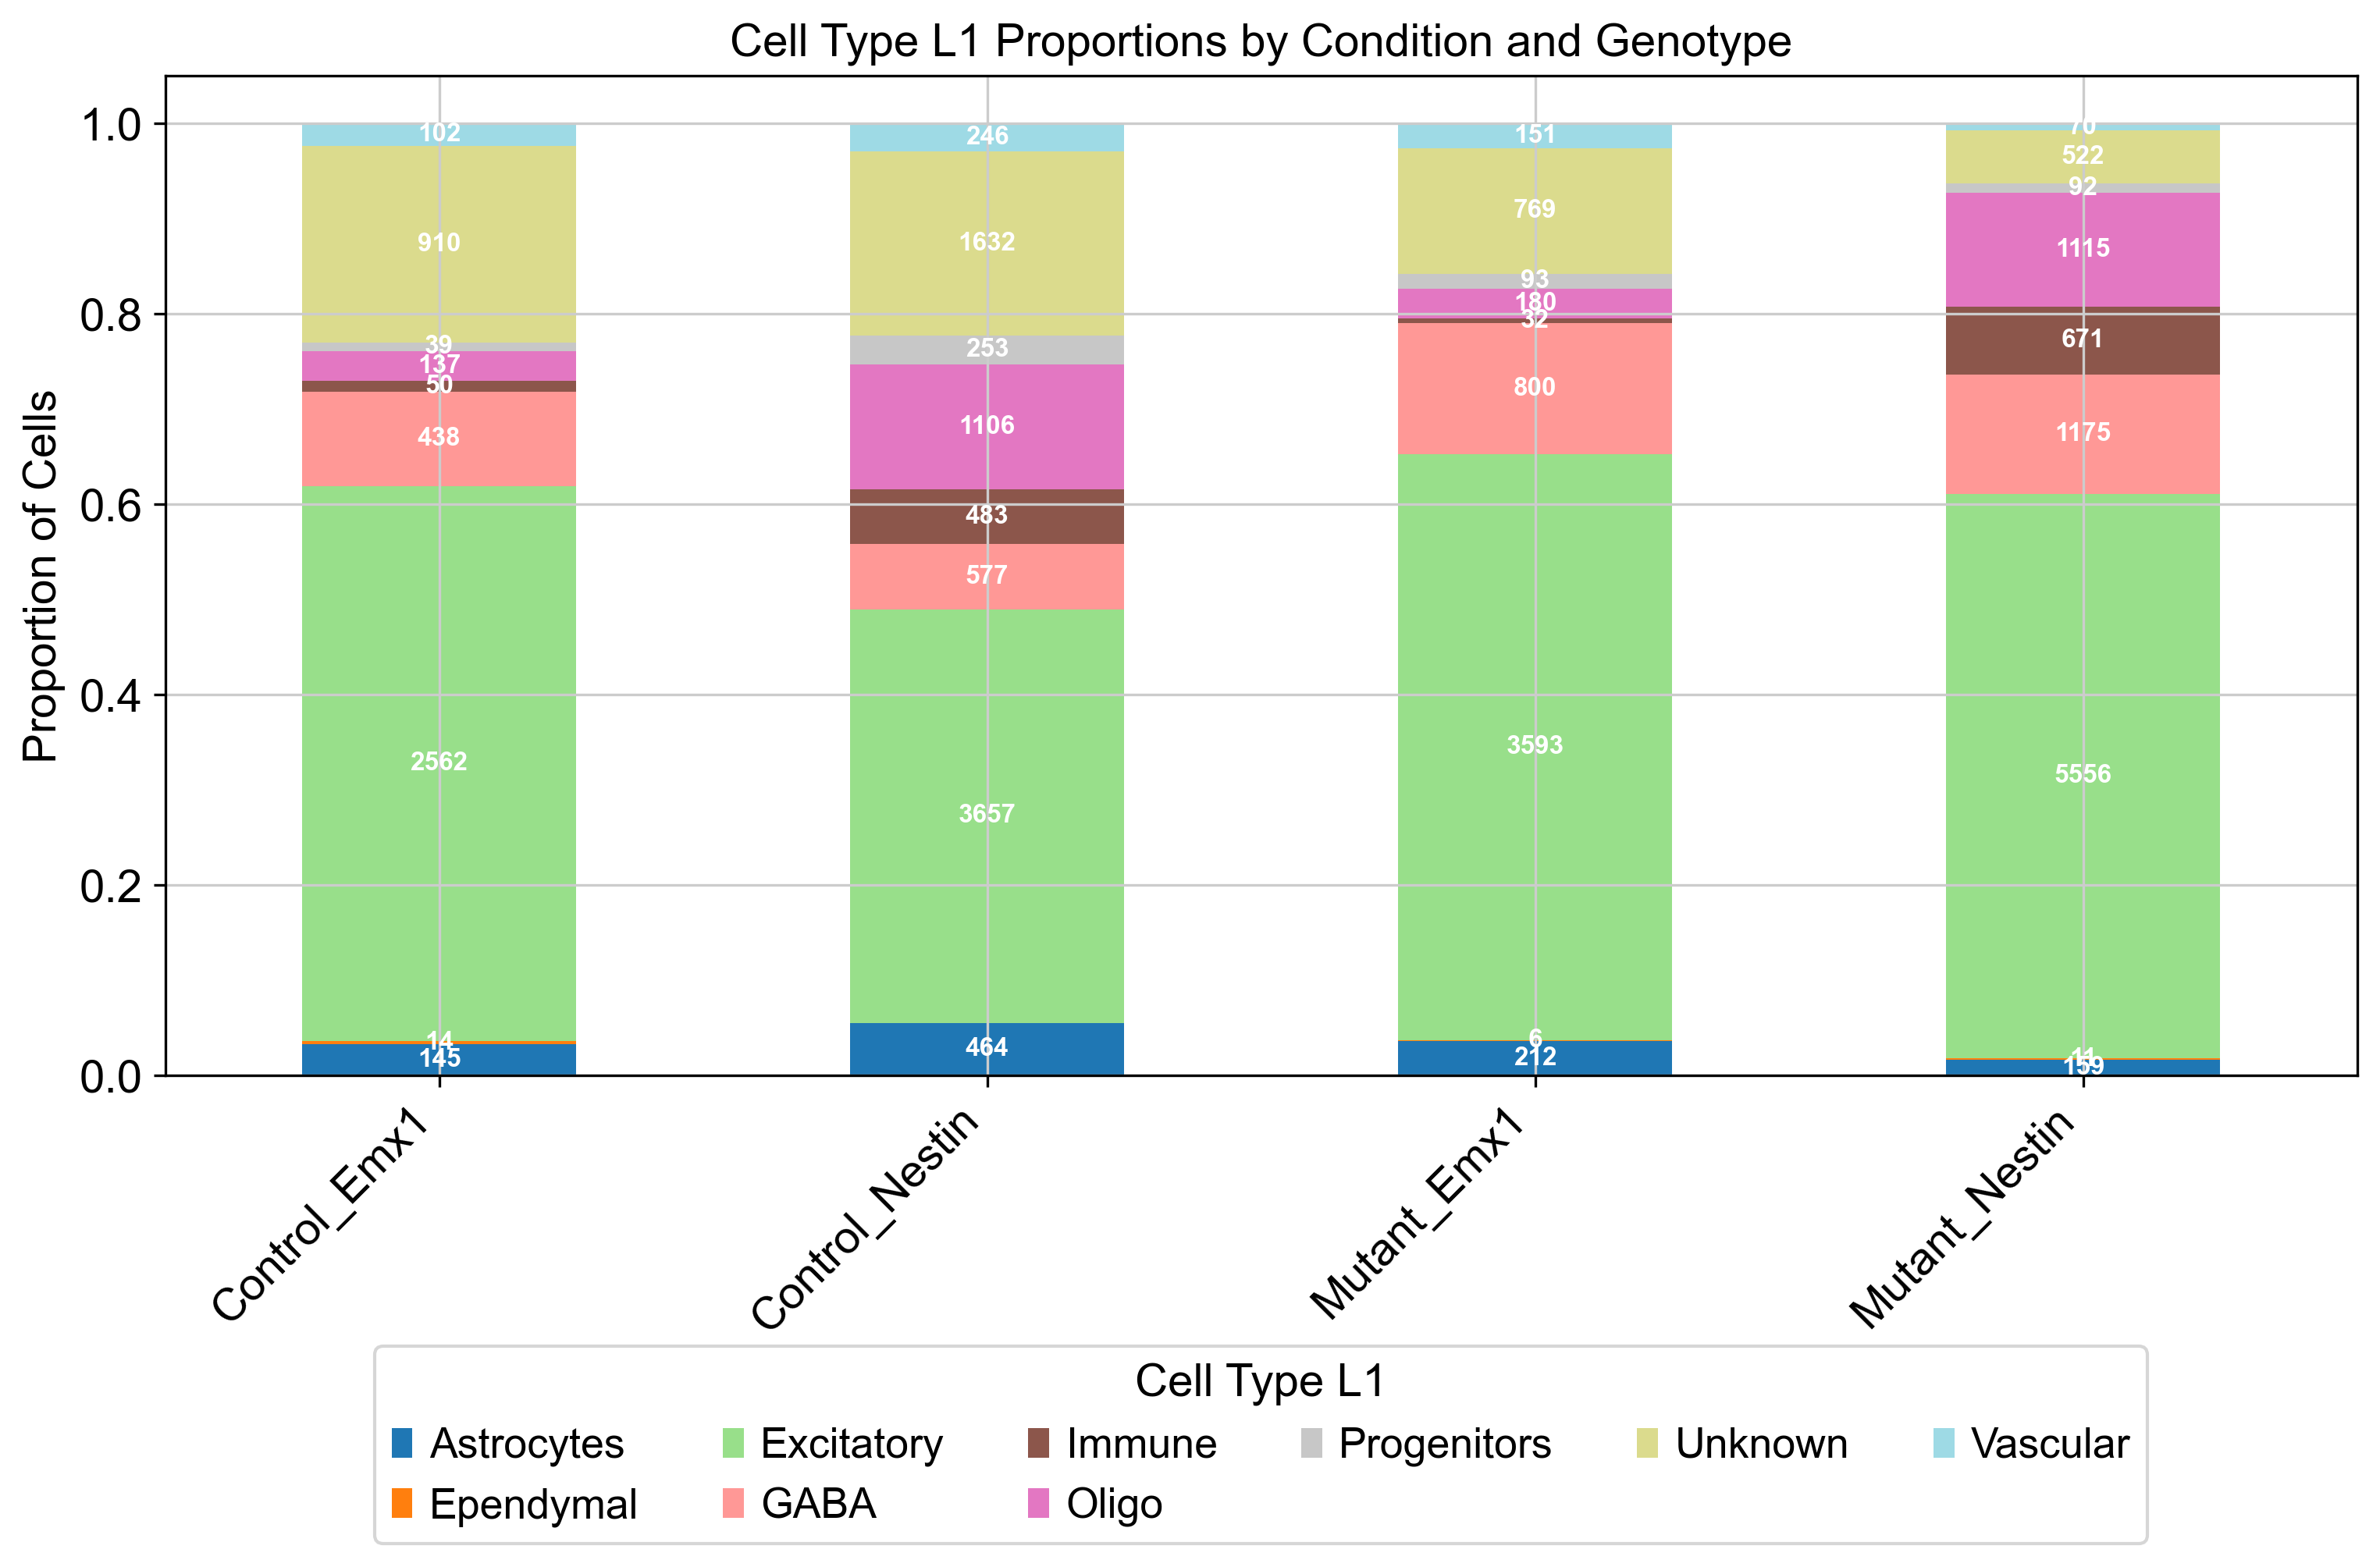


Calculating proportions for: cell_type_L2...
Proportions calculated for cell_type_L2.
Proportions table for cell_type_L2 saved to D:/Github/SRF_Linda_RNA/combine_data\results_from_raw\Cell_types_composition\cell_type_L2_proportions_by_group.csv

Generating composition summary for: cell_type_L2...
Composition summary for cell_type_L2 saved to D:/Github/SRF_Linda_RNA/combine_data\results_from_raw\Cell_types_composition\cell_type_L2_composition_summary_by_group.txt

Generating composition table (Markdown) for: cell_type_L2...
Composition table (Markdown) for cell_type_L2 saved to D:/Github/SRF_Linda_RNA/combine_data\results_from_raw\Cell_types_composition\cell_type_L2_composition_table_by_group.md

Generating proportion plot for: cell_type_L2...


C:\Users\janku\AppData\Local\Temp\ipykernel_58156\1911609722.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(adata.obs[annotation_key]): # type: ignore
C:\Users\janku\AppData\Local\Temp\ipykernel_58156\1911609722.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_df = adata.obs.groupby([group_key, annotation_key]).size().unstack(fill_value=0)


Proportion plot for cell_type_L2 saved to D:/Github/SRF_Linda_RNA/combine_data\results_from_raw\Cell_types_composition\cell_type_L2_proportions_stacked_bar.png


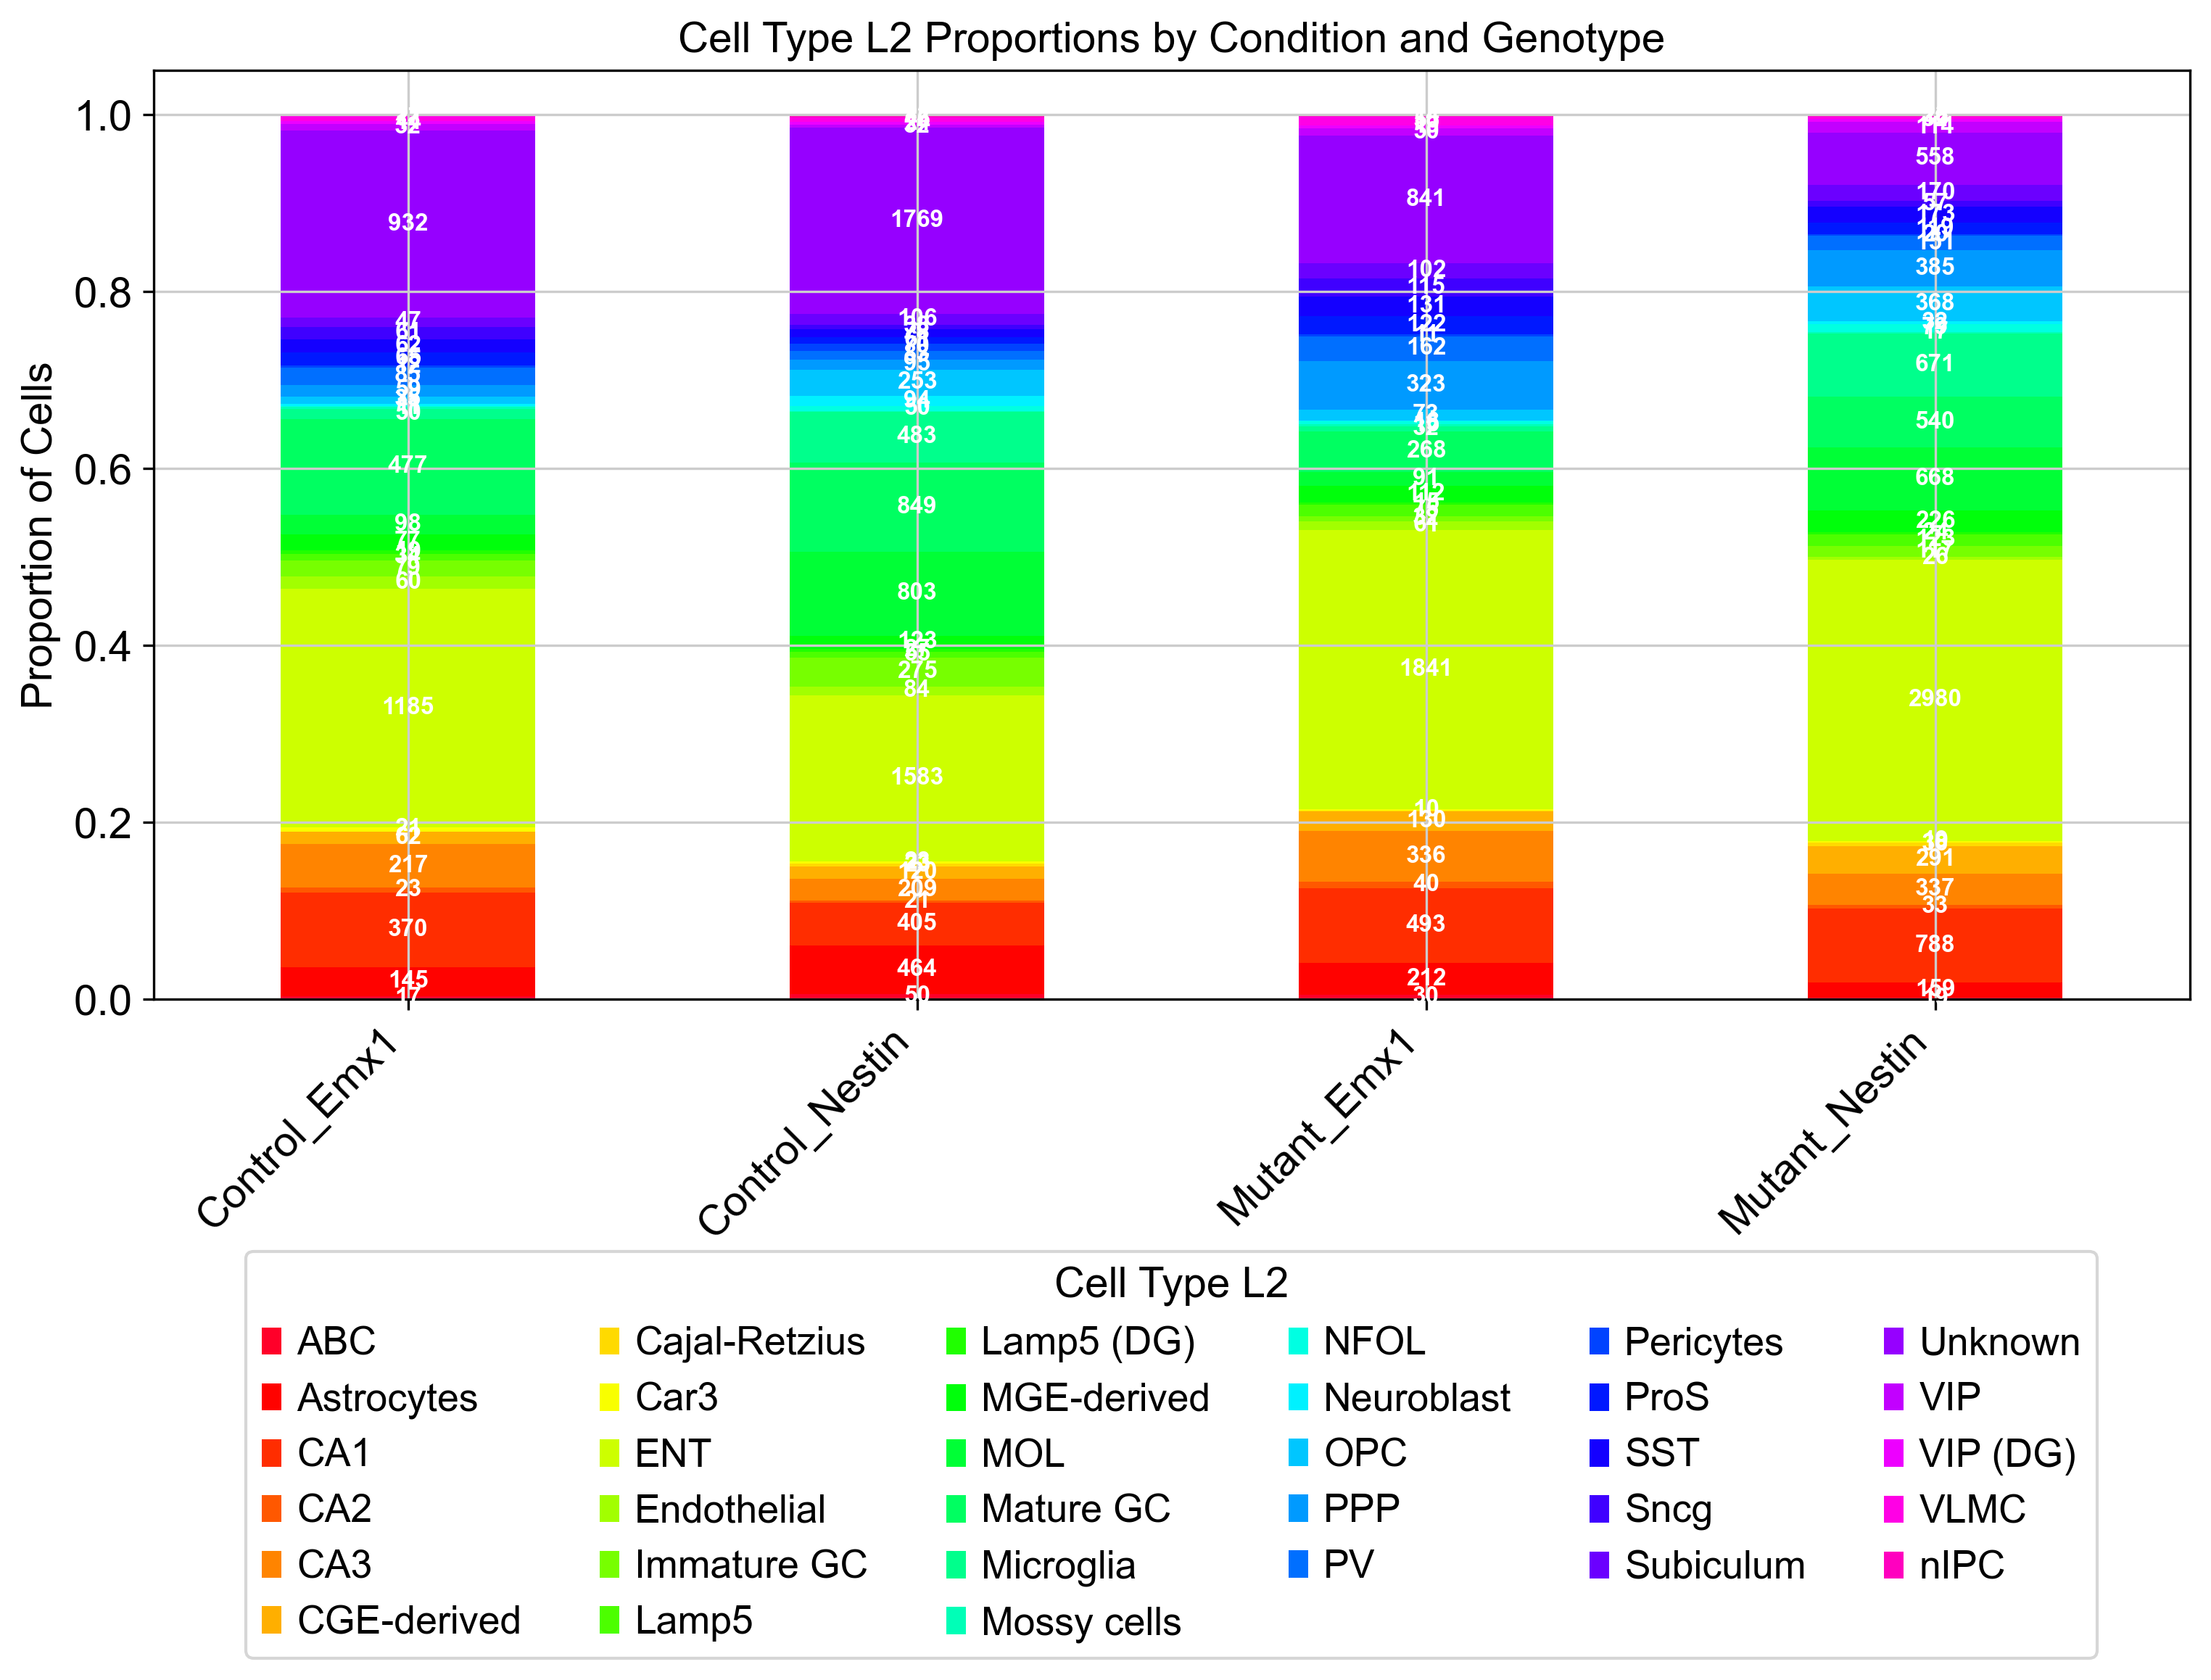


Calculating proportions for: cell_type_L2_new...
Proportions calculated for cell_type_L2_new.
Proportions table for cell_type_L2_new saved to D:/Github/SRF_Linda_RNA/combine_data\results_from_raw\Cell_types_composition\cell_type_L2_new_proportions_by_group.csv

Generating composition summary for: cell_type_L2_new...
Composition summary for cell_type_L2_new saved to D:/Github/SRF_Linda_RNA/combine_data\results_from_raw\Cell_types_composition\cell_type_L2_new_composition_summary_by_group.txt

Generating composition table (Markdown) for: cell_type_L2_new...
Composition table (Markdown) for cell_type_L2_new saved to D:/Github/SRF_Linda_RNA/combine_data\results_from_raw\Cell_types_composition\cell_type_L2_new_composition_table_by_group.md

Generating proportion plot for: cell_type_L2_new...


C:\Users\janku\AppData\Local\Temp\ipykernel_58156\1911609722.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(adata.obs[annotation_key]): # type: ignore
C:\Users\janku\AppData\Local\Temp\ipykernel_58156\1911609722.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_df = adata.obs.groupby([group_key, annotation_key]).size().unstack(fill_value=0)


Proportion plot for cell_type_L2_new saved to D:/Github/SRF_Linda_RNA/combine_data\results_from_raw\Cell_types_composition\cell_type_L2_new_proportions_stacked_bar.png


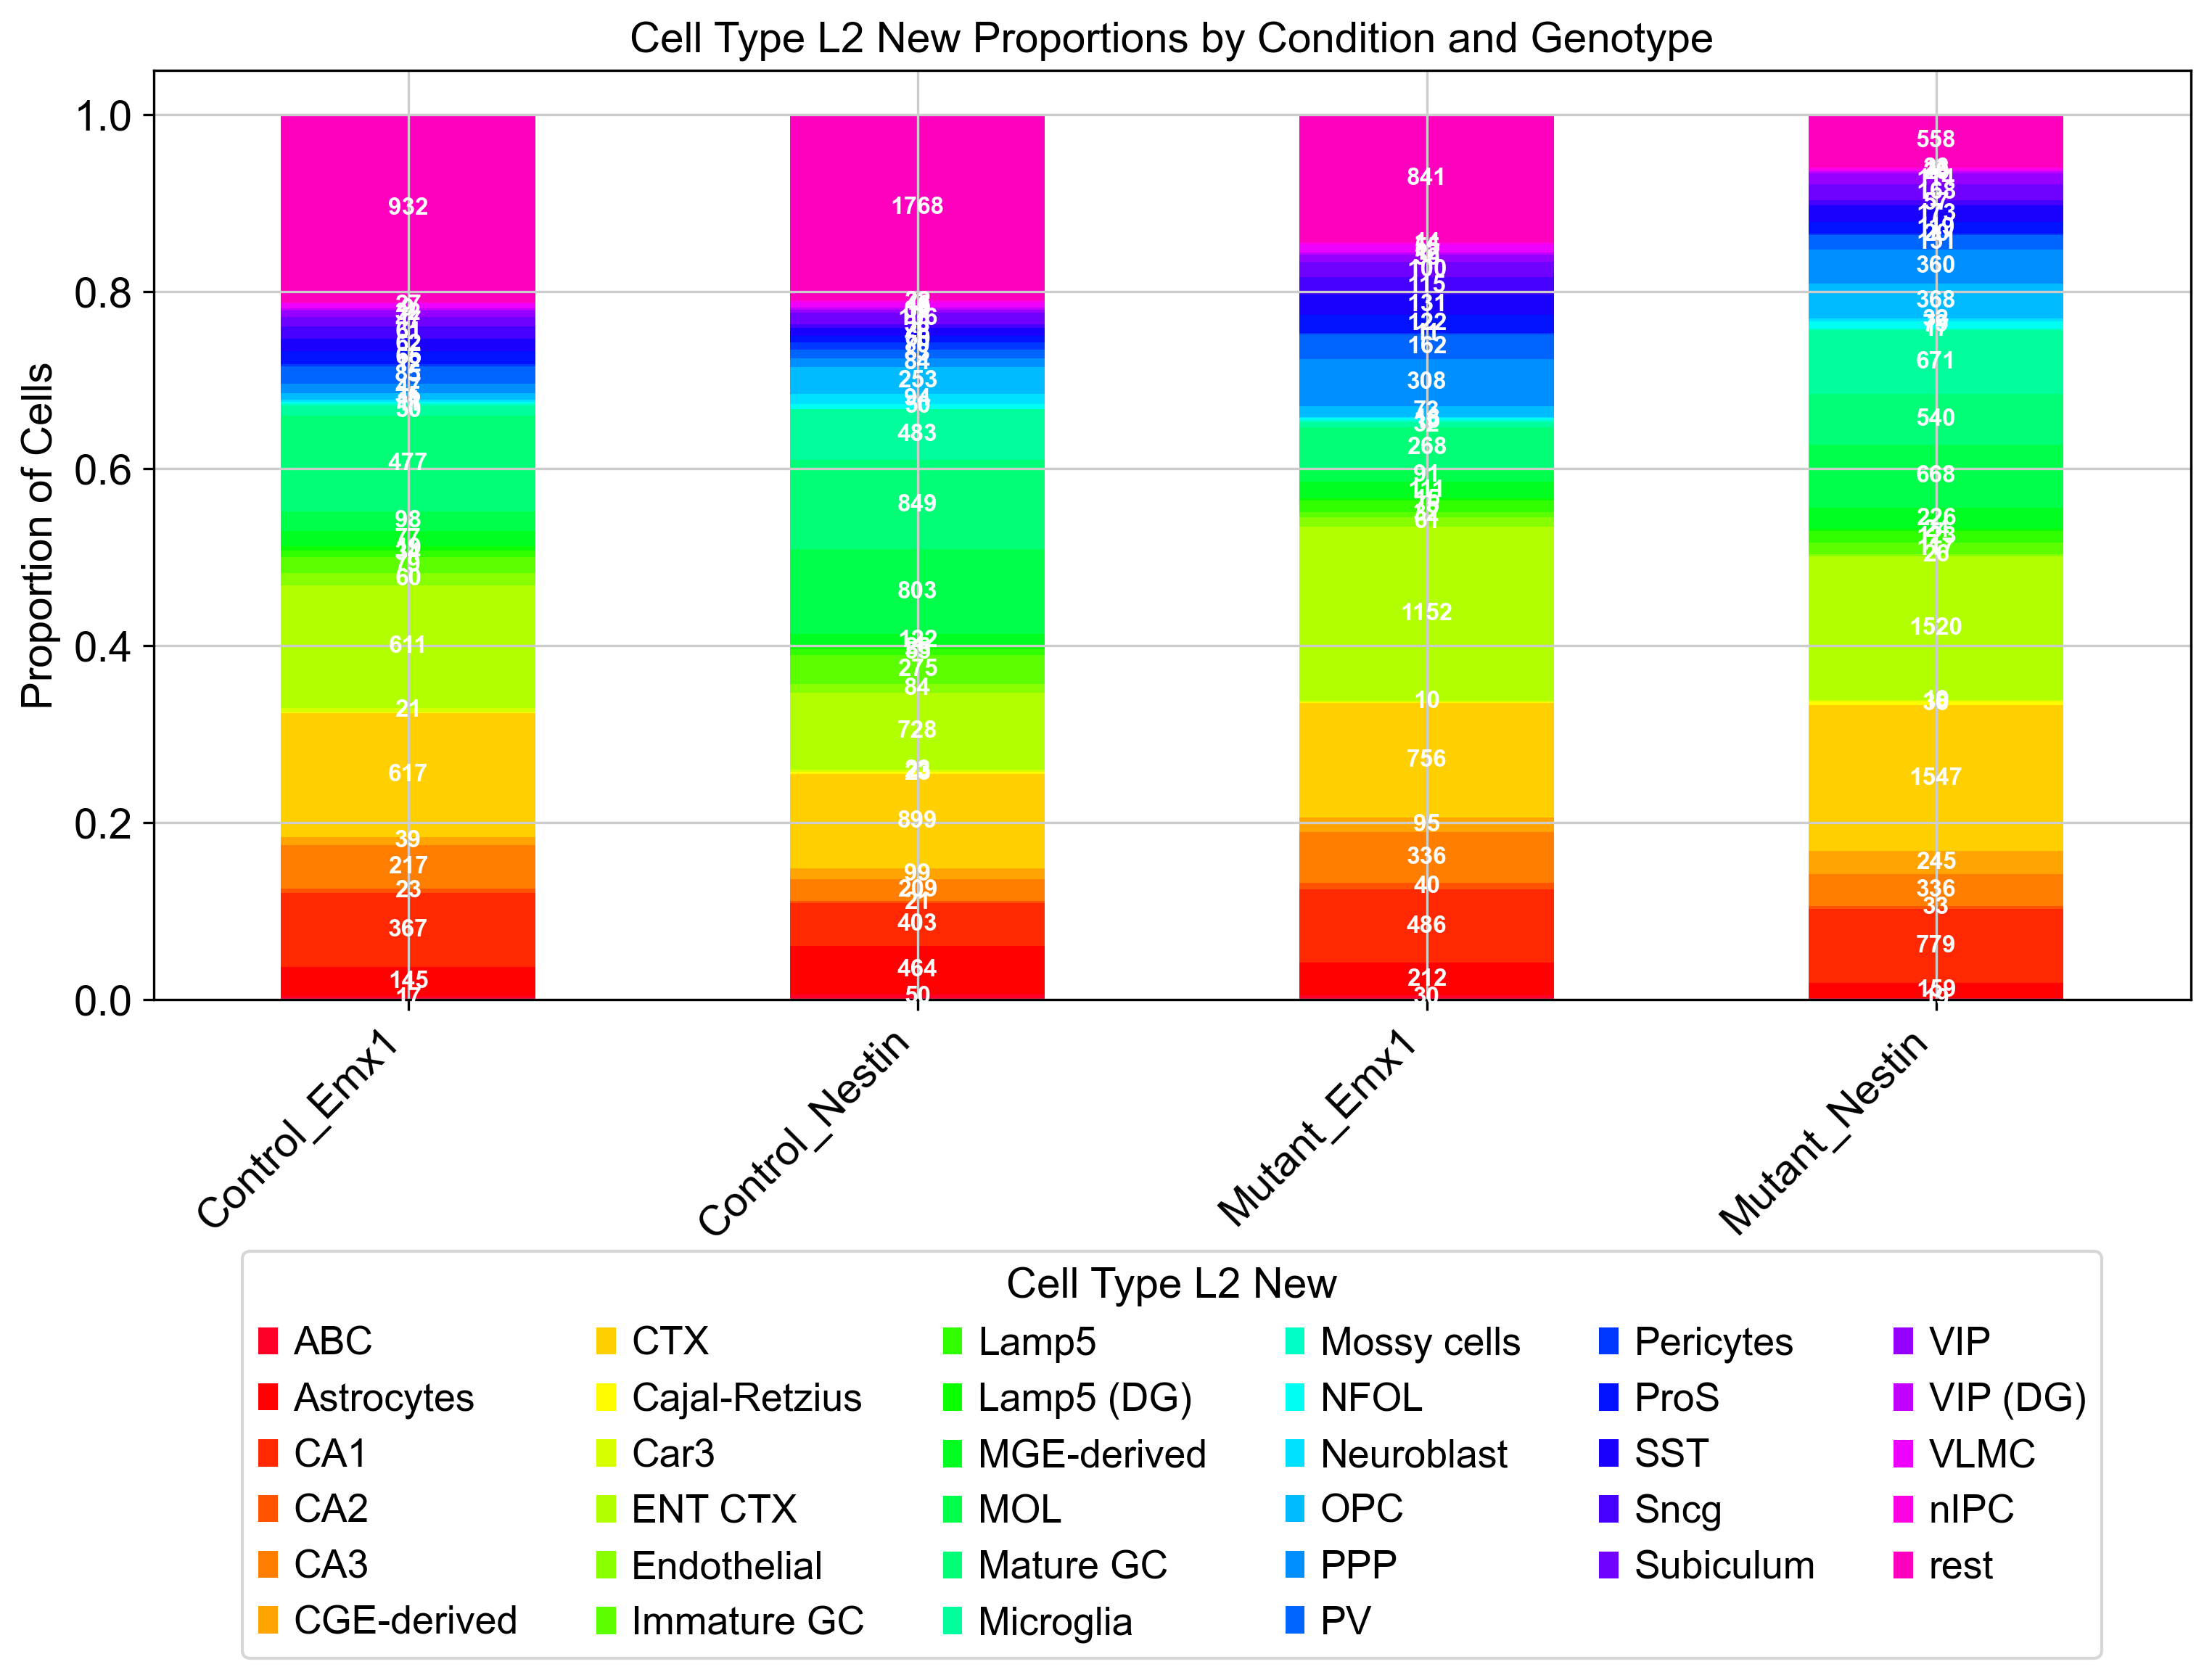

In [6]:
# 1. Calculate and Visualize Proportions for Different Annotation Levels

# Create a combined group identifier (if not already present)
if 'group' not in adata.obs.columns:
    print("Creating 'group' column (condition_genotype)...")
    adata.obs['group'] = adata.obs['condition'].astype(str) + '_' + adata.obs['genotype'].astype(str)
else:
    print("'group' column already exists.")

group_key = 'group' # Define the key used for grouping samples

# Define the annotation keys to process
annotation_keys = ['cell_type_L1', 'cell_type_L2', 'cell_type_L2_new']

# Loop through each annotation key and generate proportions/plots
for key in annotation_keys:
    calculate_and_plot_proportions(adata, key, group_key, PARENT_OUTPUT_DIR, PLOT_OUTPUT_DIR)